In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nrrd
from numpy import mean, array, log2 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from matplotlib import colormaps
from glob import glob 

font = {'family' : 'Arial',
        'size'   : 16}

plt.rc('font', **font)

In [2]:
def plotFrame(data, nx, ny, dr=0.25, idx=1, vmax=100):
    
    fig, ax = plt.subplots(figsize=(4,4))
    ax.set_aspect('equal')
    
    X, Y = np.meshgrid(range(nx),range(ny))
    xx, yy = X.flatten()*dr , Y.flatten()*dr # pixel to µm 
    
    cm = colormaps['viridis']
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    
    scat = ax.scatter(xx, yy, c=data.flatten(), cmap=cm, vmin=0, vmax=vmax)
    
    ax.set_xlabel('X (µm)')
    ax.set_ylabel('Y (µm)')
    
    if idx == 1:
        ax.set_title('Time = 0.2 s')
    else:
        ax.set_title('Time = 20 s')
    
    cbar = fig.colorbar(scat, cax=cax, orientation='vertical')
    ax.set_xticks([0,10,20])
    ax.set_yticks([0,10,20])
    
    plt.tight_layout()
    plt.show()
    
     

def get_singleFrameConcentration(file, dr=0.25, idx=1, vmax=100):
    ''' 
    file: Name of the array containing the VCell output
    dr: size of the spatial mesh (1 mesh = dr µm; e.g, 80 mesh = 20 µm)
    idx: index of the timeframe (1: second frame (array starts with zero-index), -1: last frame)
    vmax: Maximum value in the colorcode 
    '''
    
    data, header = nrrd.read(file) 
    
    print('array shape (nx, ny, nz, nt, nSpecies): ', data.shape)

    nx, ny, nz, nt, _ = data.shape
    
    # z = 0 plane, index of timeframe, one species per file 
    d2d_t = data[:,:,0,idx,0] 
    
    plotFrame(d2d_t, nx, ny, dr=dr, idx=idx, vmax=vmax)

## Concentration profile of F-actin

array shape (nx, ny, nz, nt, nSpecies):  (80, 80, 41, 41, 1)


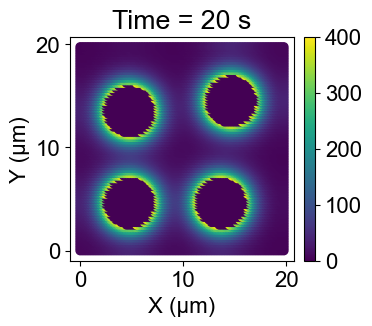

In [3]:
file_FA = '04_Ref_FA.nrrd'

get_singleFrameConcentration(file_FA, dr=0.25, idx=-1, vmax=400)

## Concentration profile of G-actin

array shape (nx, ny, nz, nt, nSpecies):  (80, 80, 41, 41, 1)


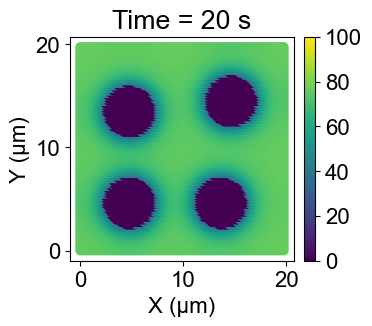

In [4]:
file_GA = '04_Ref_GA.nrrd'

get_singleFrameConcentration(file_GA, dr=0.25, idx=-1, vmax=100)

## Concentration profile of Arp2/3

array shape (nx, ny, nz, nt, nSpecies):  (80, 80, 41, 41, 1)


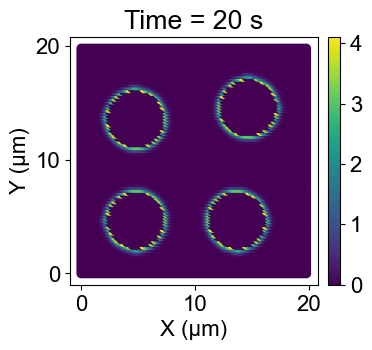

In [5]:
file_arp = '04_Ref_Arp.nrrd'

get_singleFrameConcentration(file_arp, dr=0.25, idx=-1, vmax=4.1)

## Local and Global FA concentration calculation 

In [6]:
def get_ellipsoidal_ROI(data3d, center=(20,20,0), r=24, h=24):
    '''
    data3d: Concentration profile at a given timeframe (x,y,z)
    center: Location of the condensate center 
    r, h: Radius and Height of the ROI (region of interest) outside the condensate which computes a shell volume; 
    F-actin within this shell volume is considered to compute the surface concentration.  
    For a perfect hemisphere, r = h 
    '''
    nx, ny, nz = data3d.shape 
    x = np.arange(0, nx)
    y = np.arange(0, ny)
    z1 = np.arange(0, nz)
    z2 = np.arange(-(nz-1),-1)
    z = np.concatenate((z1, z2))
    
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    xc, yc, zc = center
    
    mask = ((X-xc)**2/r**2 + (Y-yc)**2/r**2 + Z**2/h**2 <= 1) & (Z >= 0)
    
    pts = (X[mask], Y[mask], Z[mask])
    
    tmpArr = data3d[pts]
    
    # to exclude those voxels (within condensate volume) that are not accessible to F-actin or G-actin 
    tmpArr = tmpArr[tmpArr > 0] 
    data3d = data3d[data3d > 0]
    
    return mean(tmpArr.flatten()), mean(data3d.flatten())  

def plotTimeCourse_4c(file, center1, center2, center3, center4, 
                   r=10, h=10, dx=0.25, dt_data=0.5, title=''):
    '''
    file: Name of the array containing the VCell output
    center(1-4): Location of the four condensate centers
    r, h: radius and height of each condensate (unit is in µm)
    dr: size of the spatial mesh (1 mesh = dr µm; e.g, 80 mesh = 20 µm)
    dt_data: time interval of output data (1 timepoint: dt_data seconds)
    '''
    
    data, header = nrrd.read(file)
    nx, ny, nz, nt, _ = data.shape
    
    r_ROI = 1.5*r 
    h_ROI = 1.5*h
    
    global_FA = []
    local_FA = []
    
    for t in range(nt):
        d3d = data[:,:,:,int(t),0]
        sc1, _ = get_ellipsoidal_ROI(d3d, center=center1,
                                     r=r_ROI/dx, h=h_ROI/dx)
        sc2, _ = get_ellipsoidal_ROI(d3d, center=center2,
                                     r=r_ROI/dx, h=h_ROI/dx)
        sc3, _ = get_ellipsoidal_ROI(d3d, center=center3,
                                     r=r_ROI/dx, h=h_ROI/dx)
        sc4, _ = get_ellipsoidal_ROI(d3d, center=center4,
                                     r=r_ROI/dx, h=h_ROI/dx)
        
        gc = sc1 + sc2 + sc3 + sc4 
        
        lc = (sc1 + sc2 + sc3 + sc4)/4 
        
        global_FA.append(gc)
        local_FA.append(lc)
    
    tp = np.arange(nt)*dt_data
    
    plt.plot(tp, local_FA, 'r', lw=2, label='Local')
    plt.plot(tp, global_FA, 'b', lw=2, label='Global')
    plt.legend()
    plt.ylabel('F-actin (µM)')
    plt.xlabel('Time (s)')
    plt.title(title, pad=12)
    plt.ylim(-5,800)
    plt.show()

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


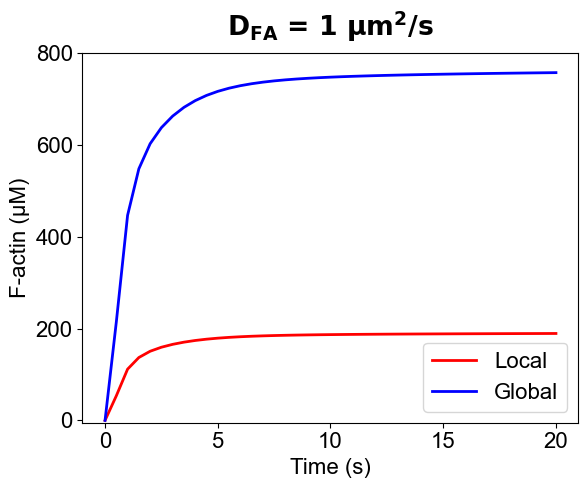

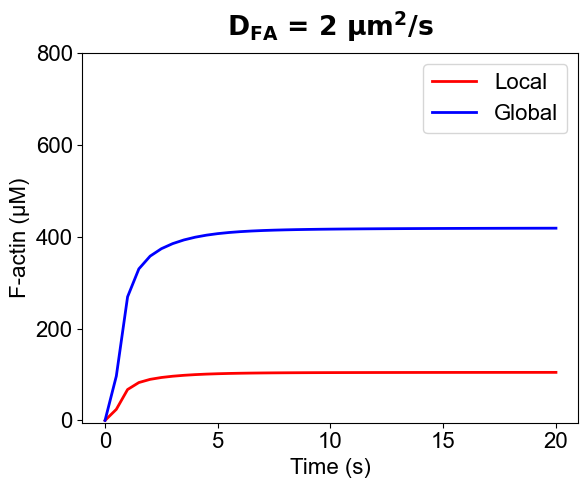

In [7]:
file_FA_ref = '04_Ref_FA.nrrd'
file_FA_FD2 = '04_FD2_FA_conc.nrrd'

center1 = (20, 20, 0)
center2 = (60, 60, 0)
center3 = (20, 56, 0)
center4 = (56, 20, 0)

plotTimeCourse_4c(file_FA_ref, center1, center2, center3, center4, r=2.519, h=2.519, dx=0.25, 
                  dt_data=0.5, title='D$_{FA}$ = 1 µm$^2$/s')

plotTimeCourse_4c(file_FA_FD2, center1, center2, center3, center4, r=2.519, h=2.519, dx=0.25, 
                  dt_data=0.5, title='D$_{FA}$ = 2 µm$^2$/s')